In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
%matplotlib inline

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in Farhi et al. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

# 1. Load the data
In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following Farhi et al. This section covers the data handling that:

Loads the raw data from Keras.
Filters the dataset to only 3s and 6s.
Downscales the images so they fit can fit in a quantum computer.
Removes any contradictory examples.
Converts the binary images to Cirq circuits.
Converts the Cirq circuits to TensorFlow Quantum circuits.


### 1.1 Load the raw data
Load the MNIST dataset distributed with Keras

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Rescale the images from [0, 255] to the [0.0, 1.0] range
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples: ",len(x_train))
print("Number of original testing examples: ",len(x_test))

11493376/11490434 [==============================] - 1s 0us/step
Number of original training examples:  60000
Number of original testing examples:  10000


Filter the dataset to keep just the 3s and 6s, remove the other classes. At the same time convert the label, y, to boolean: True for 3 and False for 6.

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print('Number of filtered training Examples: ', len(x_train))
print('Number of filtered test Examples: ', len(x_test))

Number of filtered training Examples:  12049
Number of filtered test Examples:  1968


In [6]:
x_train.shape

(12049, 28, 28, 1)

In [7]:
x_test.shape

(1968, 28, 28, 1)

True


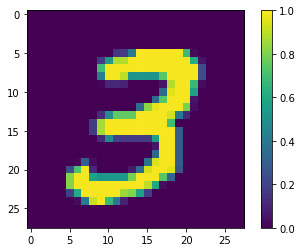

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### Downscale the images
An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [9]:
x_train_small = tf.image.resize(x_train, (4, 4)).numpy()
x_test_small = tf.image.resize(x_test, (4, 4)).numpy()

True


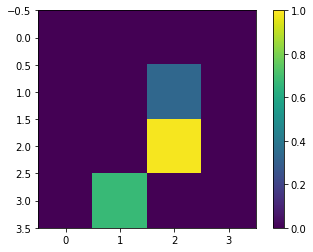

In [11]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

## 1.3 Remove contradictory examples
From section 3.3 Learning to Distinguish Digits of Farhi et al., filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [12]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    #Determine the set of labels for each unique image
    for x,y in zip(xs, ys):
        mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for x,y in zip(xs, ys):
        labels = mapping[tuple(x.flatten())]
        if(len(labels) == 1):
            new_x.append(x)
            new_y.append(list(labels)[0])
        else:
            #Throw out the images that match more than one label
            pass
    num_3 = sum(1 for value in mapping.values() if True in value)
    num_6 = sum(1 for value in mapping.values() if False in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)
    
    print('Number of unique images: ',len(mapping.values()))
    print('Number of 3s: ',num_3)
    print('Number of 6s: ',num_6)
    print('Number of Contradicting images: ',num_both)
    print()
    print('Initial Number of Examples: ',len(xs))
    print('Remaining non-contradicting examples: ',len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions.

In [13]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images:  10387
Number of 3s:  4961
Number of 6s:  5475
Number of Contradicting images:  49

Initial Number of Examples:  12049
Remaining non-contradicting examples:  11520


## 1.3 Encode the data as quantum circuits
To process images using a quantum computer, Farhi et al. proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [14]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [15]:
#When removing Contradicting images at this point we would be left with only 193, likely not enough for effective training

_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images:  193
Number of 3s:  124
Number of 6s:  113
Number of Contradicting images:  44

Initial Number of Examples:  11520
Remaining non-contradicting examples:  3731


The qubits at pixel indices with values that exceed a threshold, are rotated enough through an X gate

In [16]:
def convert_to_cicuit(image):
    """Encode truncated classical image into quantum datapoint"""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

In [18]:
x_train_circ = [convert_to_cicuit(x) for x in x_train_bin]
x_test_circ = [convert_to_cicuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

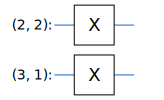

In [19]:
SVGCircuit(x_train_circ[0])

In [21]:
#Compare this circuit to the indices where image value exceeds the threshold
bin_image = x_train_bin[0, :, :, 0]
indices = np.array(np.where(bin_image)).T
indices

array([[2, 2],
       [3, 1]])

In [22]:
#Convert these Cirq Cicuits into Tensors for TFQ
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# 2. Quantum neural network
There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, Farhi et al. propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a Unitary RNN across the pixels.

## 2.1 Build the model circuit
This following example shows this layered approach. Each layer uses n instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit: 

In [23]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout) ** symbol)

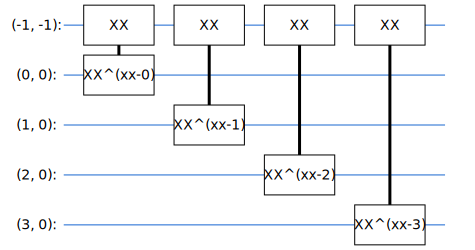

In [24]:
#Build an Example circuit layer to see how it looks
demo_builder = CircuitLayerBuilder(data_qubits=cirq.GridQubit.rect(4, 1), readout=cirq.GridQubit(-1, -1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate=cirq.XX, prefix='xx')

SVGCircuit(circuit)

In [25]:
#Now build a two layered model, matching the data-circuit size, and include the preperation and readout operations

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4) # A 4x4 grid
    readout = cirq.GridQubit(-1, -1)
    circuit = cirq.Circuit()
    
    #Prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(data_qubits=data_qubits, readout=readout)
    
    #Then add layers (experiment by adding more)
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    
    #Finally, prepare the readout qubit
    circuit.append(cirq.H(readout))
    
    return circuit, cirq.H(readout)

In [26]:
model_circuit, model_readout = create_quantum_model()

## 2.2 Wrap the model-circuit in a tfq-keras model
Build the Keras model with the quantum components. This model is fed the "quantum data", from x_train_circ, that encodes the classical data.
It uses a Parametrized Quantum Circuit layer, tfq.layers.PQC, to train the model circuit, on the quantum data.

To classify these images, Farhi et al. proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [38]:
model =  tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])
# The input is the data-circuit, encoded as a tf.string
#The PQC layer returns the expected value of the readout gate, range [-1, 1]

TypeError: operators must be a cirq.PauliSum or cirq.PauliString, or a list, tuple, or np.array containing them. Got <class 'cirq.ops.gate_operation.GateOperation'>.

To use the hinge loss here you need to make two small adjustments. First convert the labels, y_train_nocon, from boolean to [-1,1], as expected by the hinge loss.



In [34]:
x_train_hinge = 2.0*y_train_nocon-1.0
x_test_hinge = 2.0*y_test - 1.0

Second, use a custiom hinge_accuracy metric that correctly handles [-1, 1] as the y_true labels argument. tf.losses.BinaryAccuracy(threshold=0.0) expects y_true to be a boolean, and so can't be used with hinge loss).

In [35]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    
    return tf.reduce_mean(result)

In [36]:
model.compile(loss=tf.keras.losses.Hinge(), optimizer=tf.keras.optimizers.Adam(), metrics=[hinge_accuracy])

NameError: name 'model' is not defined